In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import sys
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import keras
import tensorflow as tf
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [2]:
directory = os.path.join('./data/face_extraction_mtcnn')

img_height = 256
img_width = 256
batch_size = 32
nb_epochs = 100

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    directory,
    follow_links=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory, # same directory as training data
    follow_links=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 1586 images belonging to 2 classes.
Found 396 images belonging to 2 classes.


In [3]:
learning_rate = 0.001

x = Input(shape = (img_width, img_height, 3))

x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

y = Flatten()(x4)
y = Dropout(0.5)(y)
y = Dense(16)(y)
y = LeakyReLU(alpha=0.1)(y)
y = Dropout(0.5)(y)
y = Dense(1, activation = 'sigmoid')(y)

model =  KerasModel(inputs = x, outputs = y)

optimizer = Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

In [4]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs)

Epoch 1/100
49/49 [==============================] - 46s 709ms/step - loss: 0.3266 - accuracy: 0.5463 - val_loss: 0.2979 - val_accuracy: 0.5052
Epoch 2/100
49/49 [==============================] - 33s 667ms/step - loss: 0.2743 - accuracy: 0.5824 - val_loss: 0.4108 - val_accuracy: 0.4974
Epoch 3/100
49/49 [==============================] - 32s 652ms/step - loss: 0.2481 - accuracy: 0.6158 - val_loss: 0.4463 - val_accuracy: 0.5052
Epoch 4/100
49/49 [==============================] - 32s 659ms/step - loss: 0.2428 - accuracy: 0.6313 - val_loss: 0.4511 - val_accuracy: 0.4948
Epoch 5/100
49/49 [==============================] - 32s 647ms/step - loss: 0.2331 - accuracy: 0.6422 - val_loss: 0.4194 - val_accuracy: 0.4922
Epoch 6/100
49/49 [==============================] - 32s 644ms/step - loss: 0.2203 - accuracy: 0.6680 - val_loss: 0.4070 - val_accuracy: 0.5000
Epoch 7/100
49/49 [==============================] - 32s 645ms/step - loss: 0.2162 - accuracy: 0.6712 - val_loss: 0.4224 - val_accuracy:

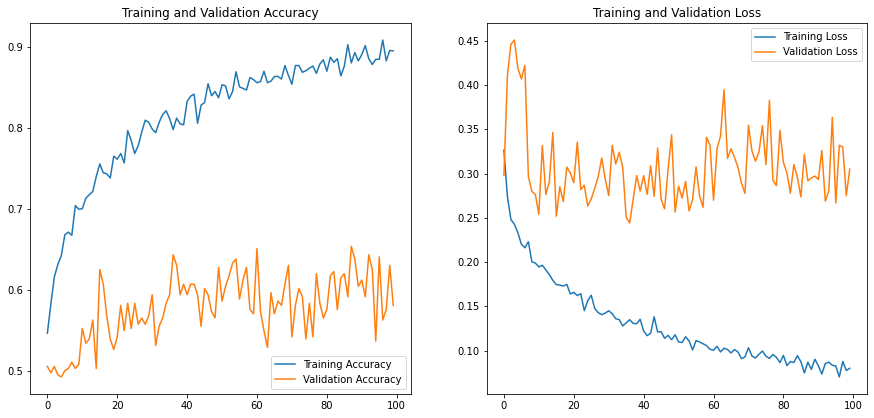

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nb_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [6]:
df = pd.DataFrame()
for idx, key in enumerate(history.history.keys()):
    row = pd.DataFrame(data={
      'item': key,
      'max': max(history.history[key]),
      'mean': np.mean(history.history[key]),
      'min': min(history.history[key]),
      'std': np.std(history.history[key]),
    }, index=[idx])
    df = pd.concat([df,row])

from IPython.display import HTML
df.sort_values(by=['item'],ascending=True)
HTML(df.to_html(index=False))


item,max,mean,min,std
loss,0.326632,0.129616,0.070224,0.048695
accuracy,0.908623,0.816244,0.546332,0.076573
val_loss,0.451105,0.307466,0.244282,0.041979
val_accuracy,0.653646,0.578047,0.492188,0.040343
